In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
database = 'database.sqlite'

In [4]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables.head()

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...


In [5]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [6]:
leagues = pd.read_sql("""SELECT *
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", conn)
leagues.head()

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy


In [7]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name
                        LIMIT 10;""", conn)
teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA


In [8]:
detailed_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER by date
                                LIMIT 10;""", conn)
detailed_matches.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0


In [10]:
leages_by_season = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY Country.name, League.name, season DESC
                                ;""", conn)
leages_by_season.head()

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066


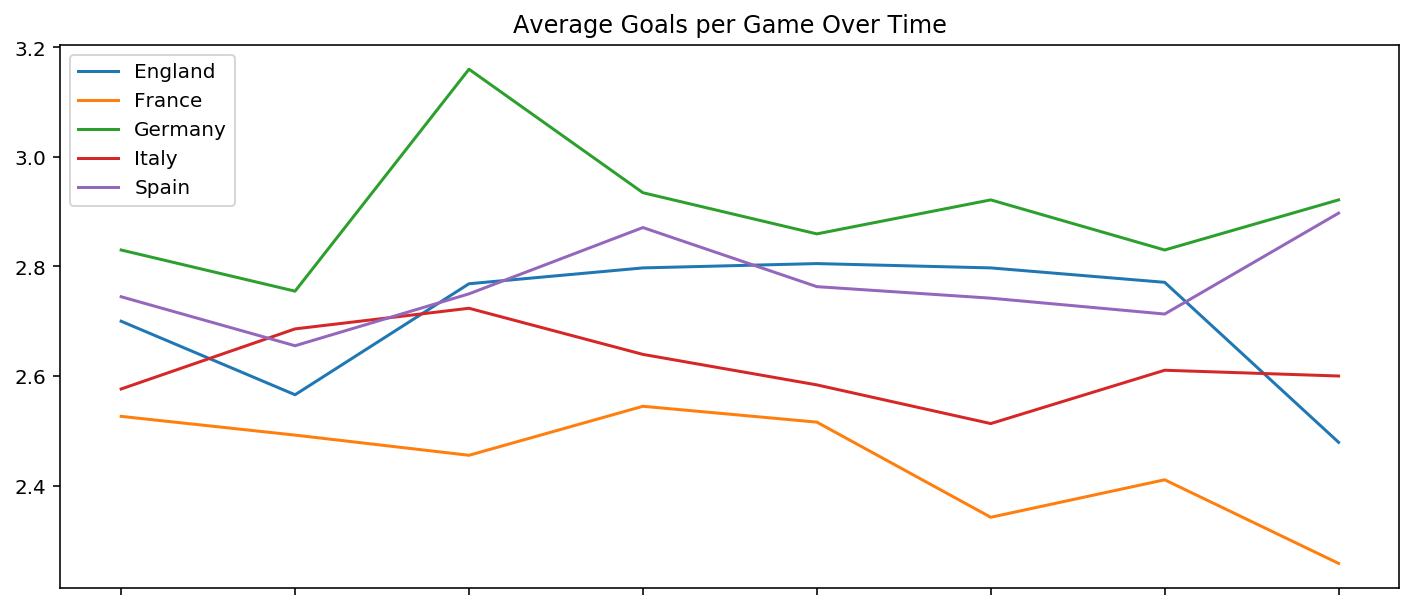

In [12]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time');

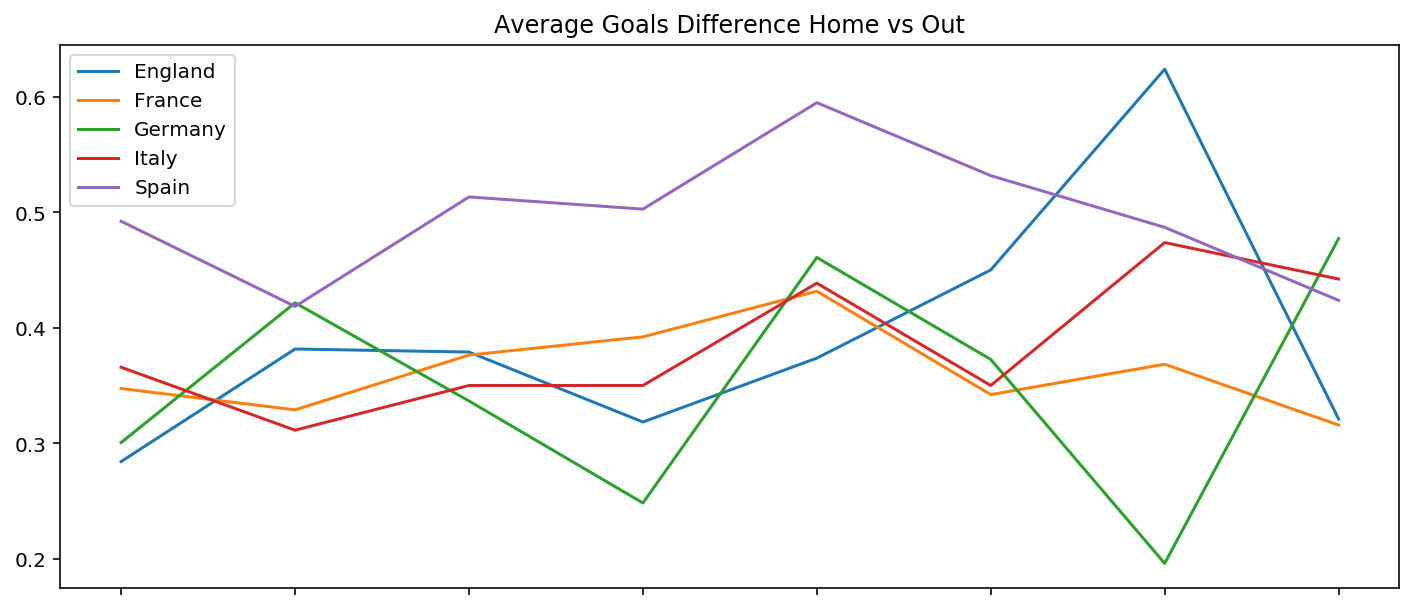

In [14]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])

df.plot(figsize=(12,5),title='Average Goals Difference Home vs Out');

In [15]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height, 
                                        COUNT(height) AS distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight 
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential  
                                        FROM Player_Attributes
                                        GROUP BY Player_Attributes.player_api_id) 
                                        AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", conn)
players_height

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


### SQL Commands
* SELECT

* FROM

* JOIN (INNER/LEFT)

* WHERE

* GROUP BY

* HAVING

* ORDER BY

* LIMIT

* ROUND